In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
import random


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/train_cleaned_rnn.csv")
test_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/test_cleaned_rnn.csv")

X = train_cleaned_data['tweet_cleaned'].values
y = train_cleaned_data['label'].values

X_test = test_cleaned_data['tweet_cleaned'].values
y_test = test_cleaned_data['label'].values

In [ ]:
def encode_data(texts, labels, tokenizer, max_length=256):
    # Sicherstellen, dass die Eingaben Strings sind
    texts = [str(text) for text in texts]

    encoded = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',  # Empfohlenes Padding
        truncation=True,  # Explizite Trunkierung
        max_length=max_length,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids']
    attention_masks = encoded['attention_mask']
    labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(input_ids, attention_masks, labels)

In [ ]:
def train_model(dataloader, model, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    return total_loss / len(dataloader)

In [ ]:
def evaluate(dataloader, model, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(input_ids=batch[0], attention_mask=batch[1], labels=batch[2])
        loss = outputs[0]
        logits = outputs[1]
        total_loss += loss.item()
        predictions.append(logits.detach().cpu().numpy())
        true_labels.append(batch[2].detach().cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return total_loss / len(dataloader), predictions, true_labels

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Tokenizer initialisieren
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Daten vorbereiten
train_data = encode_data(X_train, y_train, tokenizer)
val_data = encode_data(X_val, y_val, tokenizer)
test_data = encode_data(X_test, y_test, tokenizer)


# DataLoader erstellen
batch_size = 16
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler=RandomSampler(val_data), batch_size=batch_size)
test_dataloader = DataLoader(test_data, sampler=RandomSampler(test_data), batch_size=batch_size)

# Modell initialisieren
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binäre Klassifikation
    output_attentions=False,
    output_hidden_states=False
)

# Optimizer und Scheduler einrichten
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * epochs
)

# Seed setzen
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training und Evaluation
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}")
    train_loss = train_model(train_dataloader, model, optimizer, scheduler, device)
    print(f"Training loss: {train_loss}")
    val_loss, predictions, true_labels = evaluate(val_dataloader, model, device)
    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_labels.flatten()
    f1 = f1_score(labels_flat, preds_flat, average='weighted')
    print(f"Validation loss: {val_loss}")
    print(f"Validation F1 Score: {f1}")

Epoch 1
Training loss: 0.16788431769107331
Validation loss: 0.1273283083796384
Validation F1 Score: 0.956249050379026
Epoch 2
Training loss: 0.09771933680399604
Validation loss: 0.16885615378896784
Validation F1 Score: 0.9593253069389271
Epoch 3
Training loss: 0.056339043772590205
Validation loss: 0.17545983535073045
Validation F1 Score: 0.9626660652069345
Epoch 4
Training loss: 0.0299070204157492
Validation loss: 0.20523522632914695
Validation F1 Score: 0.962593913615873
Epoch 5
Training loss: 0.01633837297806761
Validation loss: 0.21713498210780083
Validation F1 Score: 0.963475607522447


In [ ]:
# Test-Evaluation
test_loss, predictions, true_labels = evaluate(test_dataloader, model, device)
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_labels.flatten()
test_f1 = f1_score(labels_flat, preds_flat, average='weighted')
print(f"Test Loss: {test_loss}")
print(f"Test F1 Score: {test_f1}")

Test Loss: 0.22463124784323485
Test F1 Score: 0.9616656375295234


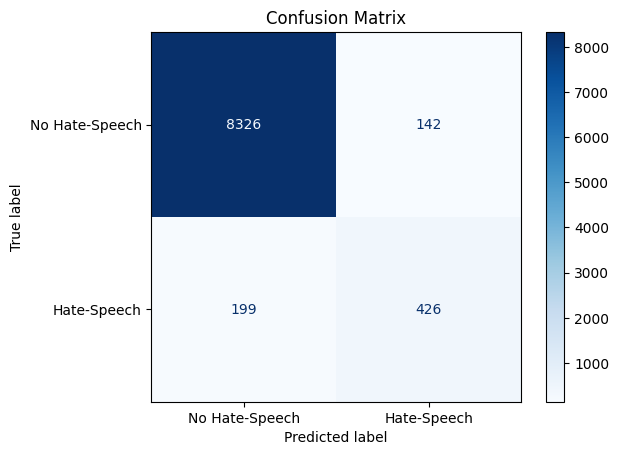

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Funktion zur Erstellung und Anzeige der Konfusionsmatrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# Test-Evaluation mit Konfusionsmatrix
test_loss, predictions, true_labels = evaluate(test_dataloader, model, device)

# Konvertiere Vorhersagen und Labels in flache Arrays
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_labels.flatten()

# Anzeige der Konfusionsmatrix
class_names = ["No Hate-Speech", "Hate-Speech"]
plot_confusion_matrix(labels_flat, preds_flat, class_names)


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(labels_flat, preds_flat, target_names=class_names)

print("Classification Report:")
print(report)

Classification Report:
                precision    recall  f1-score   support

No Hate-Speech       0.98      0.98      0.98      8468
   Hate-Speech       0.75      0.68      0.71       625

      accuracy                           0.96      9093
     macro avg       0.86      0.83      0.85      9093
  weighted avg       0.96      0.96      0.96      9093

